In [168]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
# sns.set_style()
# sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [169]:
tasks = ['hospital_mortality','sepsis','LOS_7','readmission_30','hyperkalemia_lab_mild_label','hyperkalemia_lab_moderate_label','hyperkalemia_lab_severe_label','hyperkalemia_lab_abnormal_label','hypoglycemia_lab_mild_label','hypoglycemia_lab_moderate_label','hypoglycemia_lab_severe_label','hypoglycemia_lab_abnormal_label','neutropenia_lab_mild_label','neutropenia_lab_moderate_label','neutropenia_lab_severe_label','hyponatremia_lab_mild_label','hyponatremia_lab_moderate_label','hyponatremia_lab_severe_label','hyponatremia_lab_abnormal_label','aki_lab_aki1_label','aki_lab_aki2_label','aki_lab_aki3_label','aki_lab_abnormal_label','anemia_lab_mild_label','anemia_lab_moderate_label','anemia_lab_severe_label','anemia_lab_abnormal_label','thrombocytopenia_lab_mild_label','thrombocytopenia_lab_moderate_label','thrombocytopenia_lab_severe_label','thrombocytopenia_lab_abnormal_label']
metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']
model_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/notebooks/figures'

best_clmbr_params = {'all':'gru_sz_800_do_0_lr_0.0001_l2_0', 'mix':'gru_sz_800_do_0_lr_0.0001_l2_0'}

models = ['lr']
feat_groups = ['shared', 'pediatric', 'adult']
cohort_types = ['pediatric', 'adult']

titles = {'hospital_mortality':'In-hospital\nMortality', 'sepsis':'SEPSIS-3', 'LOS_7':'Length of Stay\n> 7 days', 'icu_admission':'Admission to\nICU', 'readmission_30':'Readmission\nafter 30 days', 'aki1_label':'Acute Kidney\nInjury 1','aki2_label':'Acute Kidney\nInjury 2','hg_label':'Hypoglycemia','np_500_label':'Neutropenia\n<500','np_1000_label':'Neutropenia\n<1000'}

In [206]:
y_axis = {
    'auc':{
        'lim':[-0.35,0.1],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.32,0.18],
        'label':'AUPRC_C'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.02, 0.15],
        'label':'ACE'
    }
}

dot_shapes = {
    'PT-LR':'o',
    'FT-LR':'*',
    'PT-GBM':'s',
    'FT-GBM':'D',
    'PT-CLMBR':'^',
    'FT-CLMBR':'p'
}

model_colours = {
    # rename to model names and use as boxplot face colours
    'Count-LR_Target':'purple',
    'Count-LR_Target[Constrained]':'pink',
    'Count-LR_Source':'blue',
    'CLMBR_Source':'lightgreen',
    'CLMBR_Target':'red',
    'CLMBR_Source[Adult]':'yellow',
    'CLMBR_FT-Pre':'green',
    'CLMBR_FT-Pre[Constrained]':'turquoise',
    'CLMBR_FT-Pre[Adult]':'brown',
    'Count-LR_Ft-Task':'lightblue'
}

task_colours = {
    'hospital_mortality':'#8C8C8C', #dark grey
    'sepsis':'#ccb974', #tan brown
    'LOS_7':'#937860', # dark brown
    'readmission_30':'#cfcfcf', #light gray
    'hyperkalemia_lab_mild_label':'#55aa99', #turquoise 1 
    'hyperkalemia_lab_moderate_label':'#41756b', #turqoise 2
    'hyperkalemia_lab_severe_label':'#375b54', #turqoise 3
    'hyperkalemia_lab_abnormal_label':'#2d413d', #turqoise 4
    'hypoglycemia_lab_mild_label':'#008000', # green 1
    'hypoglycemia_lab_moderate_label':'#0d5c0d', # green 2
    'hypoglycemia_lab_severe_label':'#144b14', # green 3
    'hypoglycemia_lab_abnormal_label':'#1b391b', # green 4
    'neutropenia_lab_mild_label':'#ffc0cb', # pink1 
    'neutropenia_lab_moderate_label':'#ac8188', # pink 2
    'neutropenia_lab_severe_label':'#594246', # pink 3
    'hyponatremia_lab_mild_label':'#ff0000', # red 1
    'hyponatremia_lab_moderate_label':'#ad0e0e', # red 2
    'hyponatremia_lab_severe_label':'#831414', # red 3
    'hyponatremia_lab_abnormal_label':'#5a1b1b', # red 4
    'aki_lab_aki1_label':'#800080', # purple 1
    'aki_lab_aki2_label':'#5e0e5e', # purple 2
    'aki_lab_aki3_label':'#4d154d', # purple 3
    'aki_lab_abnormal_label':'#3c1c3c', # purple 4
    'anemia_lab_mild_label':'#ffa500', # orange 1
    'anemia_lab_moderate_label':'#d48b07', # orange 2
    'anemia_lab_severe_label':'#7f5814', # orange 3
    'anemia_lab_abnormal_label':'#543e1b', # orange 4
    'thrombocytopenia_lab_mild_label':'#0000ff', # blue 1
    'thrombocytopenia_lab_moderate_label':'#0f0fad', # blue 2
    'thrombocytopenia_lab_severe_label':'#161684', # blue 3
    'thrombocytopenia_lab_abnormal_label':'#1d1d5c' # blue 4
}

In [171]:
palette_list = [task_colours[task] for task in tasks]
print(palette_list)
task_palette = sns.color_palette(palette_list)

['#8C8C8C', '#ccb974', '#937860', '#cfcfcf', '#55aa99', '#41756b', '#375b54', '#2d413d', '#008000', '#0d5c0d', '#144b14', '#1b391b', '#ffc0cb', '#ac8188', '#594246', '#ff0000', '#ad0e0e', '#831414', '#5a1b1b', '#800080', '#5e0e5e', '#4d154d', '#3c1c3c', '#ffa500', '#d48b07', '#7f5814', '#543e1b', '#0000ff', '#0f0fad', '#161684', '#1d1d5c']


In [172]:
print(sns.color_palette("dark:blue_r").as_hex())

['#0000ff', '#0707d6', '#0f0fad', '#161684', '#1d1d5c', '#242433']


In [173]:
sns.color_palette("dark:blue_r")

[(0.0, 0.0, 1.0),
 (0.028578343256650714, 0.02857916642048089, 0.8398397039847683),
 (0.05715668651330143, 0.05715833284096178, 0.6796794079695364),
 (0.08573502976995213, 0.08573749926144267, 0.5195191119543047),
 (0.11431337302660285, 0.11431666568192356, 0.3593588159390728),
 (0.14289171628325356, 0.14289583210240445, 0.19919851992384108)]

In [174]:
print(sns.color_palette().as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [189]:
model_palette_list = [model_colours[k] for k in model_colours.keys()]

In [175]:
# Get baseline model
lr_df = pd.DataFrame()
print('LR')
for task in tasks:
    for trc in ['adult', 'pediatric', 'constrain']:
        for tstc in ['pediatric', 'adult']:
            for fg in feat_groups:
                df = pd.read_csv(f'{results_path}/lr/{task}/tr_{trc}_tst_{tstc}/shared_feats/best/test_eval.csv')
                df['task'] = task
                df['train_cohort'] = trc
                df['test_cohort'] = tstc
                df['cohort'] = trc
                df['model'] = 'LR'
                df['feature_group'] = fg
                lr_df = pd.concat([lr_df,df])

# ft_lr_df = pd.DataFrame()
# for task in tasks:
#     for trc in ['adult', 'pediatric']:
#         for tstc in ['pediatric']: # 'adult']:
#             for fg in feat_groups:
#                 df = pd.read_csv(f'{results_path}/lr_ft/{task}/tr_{trc}_tst_{tstc}/shared_feats/best/test_eval.csv')
#                 df['task'] = task
#                 df['cohort'] = ct
#                 df['model'] = 'FT-LR'
#                 df['feature_group'] = fg
#                 ft_lr_df = pd.concat([ft_lr_df,df])

# pt_gbm_df = pd.DataFrame()
# for ct in cohort_types:
#     for task in tasks:
#         for fg in feat_groups:
#             df = pd.read_csv(f'{results_path}/{ct}/gbm/{task}/{fg}_feats/best/test_eval.csv')
#             df['task'] = task
#             df['cohort'] = ct
#             df['model'] = 'PT-GBM'
#             df['feature_group'] = fg
#             pt_gbm_df = pd.concat([pt_gbm_df,df])
            
# ft_gbm_df = pd.DataFrame()
# for ct in ['adult']:
#     for task in tasks:
#         for fg in feat_groups:
#             df = pd.read_csv(f'{results_path}/{ct}/gbm_ft/{task}/{fg}_feats/best/test_eval.csv')
#             df['task'] = task
#             df['cohort'] = ct
#             df['model'] = 'FT-GBM'
#             df['feature_group'] = fg
#             ft_gbm_df = pd.concat([ft_gbm_df,df])
print('PED CLMBR')
ped_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['ped']:
        for tr_cht in ['ped']:
            for tst_cht in ['ped']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/pretrained/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_Target'
                        ped_clmbr_df = pd.concat([ped_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
print('AD CLMBR')
ad_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['ad']:
        for tr_cht in ['ad']:
            for tst_cht in ['ad','ped']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/pretrained/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_Source[Adult]'
                        ad_clmbr_df = pd.concat([ad_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
print('ALL CLMBR')
all_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['all']:
        for tr_cht in ['ad']:
            for tst_cht in ['ped', 'ad']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/pretrained/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_Source'
                        all_clmbr_df = pd.concat([all_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
print('Ft-Pre CLMBR')
ftp_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['all']:
        for tr_cht in ['ped']:
            for tst_cht in ['ped']:
                for lr in ['0.0001']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/finetuned/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_FT-Pre'
                        ftp_clmbr_df = pd.concat([ftp_clmbr_df,df])
                    except:
                        print(f'missing {tst_cht} {task} eval')
print('FT-Pre[Adult]')
ad_ftp_clmbr_df = pd.DataFrame()
for task in tasks:
    for ct in ['ad']:#, 'ad']:#,  'ad', 'ped']:
        for tr_cht in ['ad','ped']:
            for tst_cht in ['ad','ped']:
                for lr in ['0.0001']:#, '1e-5']:
                    try:
                        df = pd.read_csv(f'{results_path}/clmbr/finetuned/{ct}/{task}/tr_{tr_cht}_tst_{tst_cht}/gru_sz_800_do_0_lr_{lr}_l2_0/test_eval.csv')
                        df['task'] = task
                        df['cohort'] = ct
                        df['train_adapter'] = tr_cht
                        df['test_adapter'] = tst_cht
                        df['model'] = 'CLMBR_FT-Pre[Adult]'
                        ad_ftp_clmbr_df = pd.concat([ad_ftp_clmbr_df,df])
                    except:
                        print(f'missing {ct} {tst_cht} {task} eval')
                
all_clmbr_df = all_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
ftp_clmbr_df = ftp_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})

ped_clmbr_df = ped_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
ad_clmbr_df = ad_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
ad_ftp_clmbr_df = ad_ftp_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})

LR
PED CLMBR
AD CLMBR
ALL CLMBR
Ft-Pre CLMBR
FT-Pre[Adult]
missing ad ped hospital_mortality eval
missing ad ad hospital_mortality eval
missing ad ped sepsis eval
missing ad ad sepsis eval
missing ad ped LOS_7 eval
missing ad ad LOS_7 eval
missing ad ped readmission_30 eval
missing ad ad readmission_30 eval
missing ad ped hyperkalemia_lab_mild_label eval
missing ad ad hyperkalemia_lab_mild_label eval
missing ad ped hyperkalemia_lab_moderate_label eval
missing ad ad hyperkalemia_lab_moderate_label eval
missing ad ped hyperkalemia_lab_severe_label eval
missing ad ad hyperkalemia_lab_severe_label eval
missing ad ped hyperkalemia_lab_abnormal_label eval
missing ad ad hyperkalemia_lab_abnormal_label eval
missing ad ped hypoglycemia_lab_mild_label eval
missing ad ad hypoglycemia_lab_mild_label eval
missing ad ped hypoglycemia_lab_moderate_label eval
missing ad ad hypoglycemia_lab_moderate_label eval
missing ad ped hypoglycemia_lab_severe_label eval
missing ad ad hypoglycemia_lab_severe_label

In [ ]:
df = ft_gbm_df
for task in tasks:
    t_df = df.query("test_group=='test' and metric=='auc' and feature_group=='shared' and task==@task and cohort=='adult'")
    print(task)
    print(f"{round(t_df['CI_med'].values[0],3)}\n({round(t_df['CI_lower'].values[0],3)}, {round(t_df['CI_upper'].values[0],3)})")

In [ ]:
df = all_clmbr_df
for cohort in ['all']:# 'ad', 'ped']
    print(cohort)
    for task in tasks:
        t_df = df.query("metric=='auc' and task==@task and cohort==@cohort")
        print(task)
        print(f"{round(t_df['performance'][0], 3)}")


In [208]:
metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']
scenarios = ['s1m', 's1s1', 's1s2', 's1s3', 's2m', 's2s1', 's3m', 's3s1']
plot_dict = {}
for s in scenarios:
    plot_dict[s] = {}
    for metric in metrics:
        plot_dict[s][metric] = pd.DataFrame()
        if s == 's1m': #Scenario 1 main figure looking at OOD performance between Count-LR_Source and CLMBR_Source
            lr_source = lr_df.query("train_cohort=='adult' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_source['performance'],'task':lr_source['task'],'Model':'Count-LR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_source = pt_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'task':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
        elif s == 's1s1': # Scenario 1 supplementary 1 looking at ID performance of Count-LR_Source and CLMBR_Source
            
            lr_source = lr_df.query("train_cohort=='adult' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='adult'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_source['performance'],'task':lr_source['task'],'Model':'Count-LR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ad'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'task':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
        elif s == 's1s2': # Scenario 1 supplementary 2 looking at OOD performance of CLMBR_Source vs CLMBR_Source[Adult] 
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'task':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_adult = ad_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='ad' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_adult['performance'],'task':clmbr_adult['task'],'Model':'CLMBR_Source[Adult]'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
        elif s == 's1s3': # Scenario 1 supplementary 3 looking at change in performance from ID to OOD for CLMBR_Source 
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'task':clmbr_source['task'],'Model':'CLMBR_Source', 'Test':'ped'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_source = all_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ad'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'task':clmbr_source['task'],'Model':'CLMBR_Source', 'Test':'ad'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
        elif s == 's2m':
            lr_bl = lr_df.query("train_cohort=='pediatric' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_bl['performance'],'task':lr_bl['task'],'Model':'Count-LR_Target'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_target = ped_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='ped' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_target['performance'],'task':clmbr_target['task'],'Model':'CLMBR_Target'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_source = pt_clmbr_df.query("train_adapter=='ad' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_source['performance'],'task':clmbr_source['task'],'Model':'CLMBR_Source'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))

            clmbr_ftp = ftp_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ftp['performance'],'task':clmbr_ftp['task'],'Model':'CLMBR_FT-Pre'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
        elif s == 's2s1':
            clmbr_ftp = ftp_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='all' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ftp['performance'],'task':clmbr_ftp['task'],'Model':'CLMBR_FT-Pre'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            clmbr_ad_ftp = ad_ftp_clmbr_df.query("train_adapter=='ped' and metric==@metric and cohort=='ad' and metric==@metric and test_adapter=='ped'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':clmbr_ftp['performance'],'task':clmbr_ftp['task'],'Model':'CLMBR_FT-Pre[Adult]'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
        elif s == 's3m':
            
            lr_bl = lr_df.query("train_cohort=='pediatric' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_bl['performance'],'task':lr_bl['task'],'Model':'Count-LR_Target'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
            
            lr_bl = lr_df.query("train_cohort=='constrain' and metric==@metric and feature_group=='shared' and metric==@metric and test_cohort=='pediatric'")[['performance', 'task']]
            df = pd.DataFrame({'Performance':lr_bl['performance'],'task':lr_bl['task'],'Model':'Count-LR_Target[Constrained]'})
            plot_dict[s][metric] = pd.concat((plot_dict[s][metric],df))
        
            
        else:
            pass

In [205]:
print('OOD')
print(plot_dict['s1m']['auc'].query('task=="sepsis"')['Performance'])
print('ID')
print(plot_dict['s1s1']['auc'].query('task=="sepsis"')['Performance'])

OOD
0    0.700919
0    0.894898
Name: Performance, dtype: float64
ID
0    0.843349
0    0.932279
Name: Performance, dtype: float64


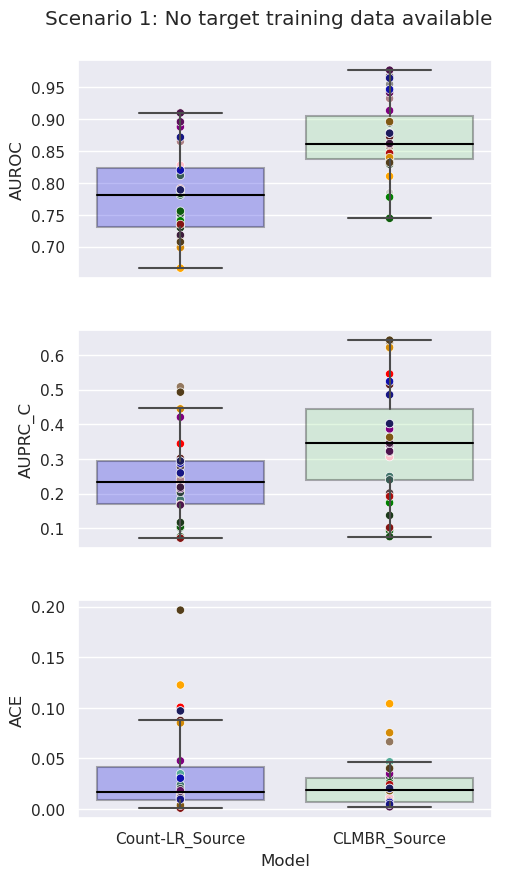

In [191]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(5,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 1: No target training data available ')
for r, metric in enumerate(metrics):
    df = plot_dict['s1m'][metric]
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='task',  palette=sns.color_palette(palette_list), ax=axs[r])

#     lp = sns.lineplot(x="Model", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r])
    h,l = sp.axes.get_legend_handles_labels()
    sp.legend_.remove()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])

# sp.fig.legend(h,l, ncol=6)

# increase dpi, reduce figsiz
#fix styling

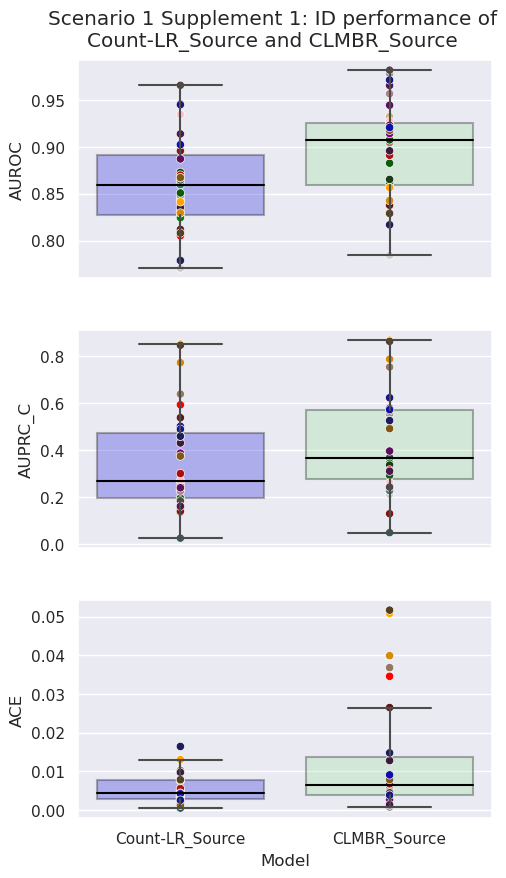

In [192]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(5,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 1 Supplement 1: ID performance of\nCount-LR_Source and CLMBR_Source')
for r, metric in enumerate(metrics):
    df = plot_dict['s1s1'][metric]
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours) 
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='task',  palette=sns.color_palette(palette_list), ax=axs[r])
#     print(df)
#     lp = sns.lineplot(x="Model", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r])
    h,l = sp.axes.get_legend_handles_labels()
    sp.legend_.remove()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])

# increase dpi, reduce figsiz
#fix styling

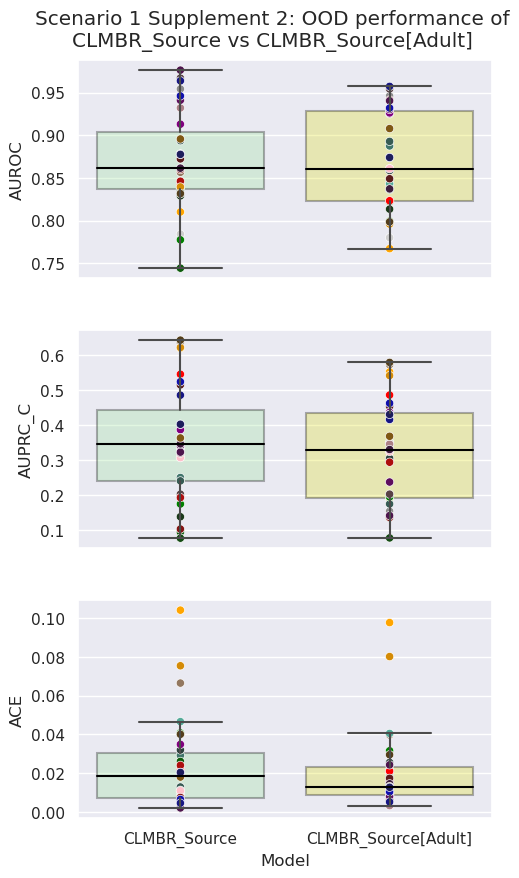

In [193]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(5,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 1 Supplement 2: OOD performance of\nCLMBR_Source vs CLMBR_Source[Adult]')
for r, metric in enumerate(metrics):
    df = plot_dict['s1s2'][metric]
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='task',  palette=sns.color_palette(palette_list), ax=axs[r])
#     print(df)
#     lp = sns.lineplot(x="Model", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r])
    h,l = sp.axes.get_legend_handles_labels()
    sp.legend_.remove()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])

# increase dpi, reduce figsiz
#fix styling

['hypoglycemia_lab_moderate_label', 'hypoglycemia_lab_mild_label', 'hyperkalemia_lab_moderate_label', 'hypoglycemia_lab_severe_label', 'hyperkalemia_lab_mild_label', 'hyponatremia_lab_severe_label', 'neutropenia_lab_mild_label', 'LOS_7', 'hyperkalemia_lab_abnormal_label', 'anemia_lab_mild_label', 'hyponatremia_lab_moderate_label', 'sepsis', 'hypoglycemia_lab_abnormal_label', 'aki_lab_abnormal_label', 'neutropenia_lab_moderate_label', 'hospital_mortality', 'anemia_lab_severe_label', 'neutropenia_lab_severe_label', 'thrombocytopenia_lab_severe_label', 'aki_lab_aki2_label', 'anemia_lab_moderate_label', 'aki_lab_aki1_label', 'readmission_30', 'hyperkalemia_lab_severe_label', 'anemia_lab_abnormal_label', 'aki_lab_aki3_label', 'hyponatremia_lab_mild_label', 'thrombocytopenia_lab_moderate_label', 'hyponatremia_lab_abnormal_label', 'thrombocytopenia_lab_abnormal_label', 'thrombocytopenia_lab_mild_label']


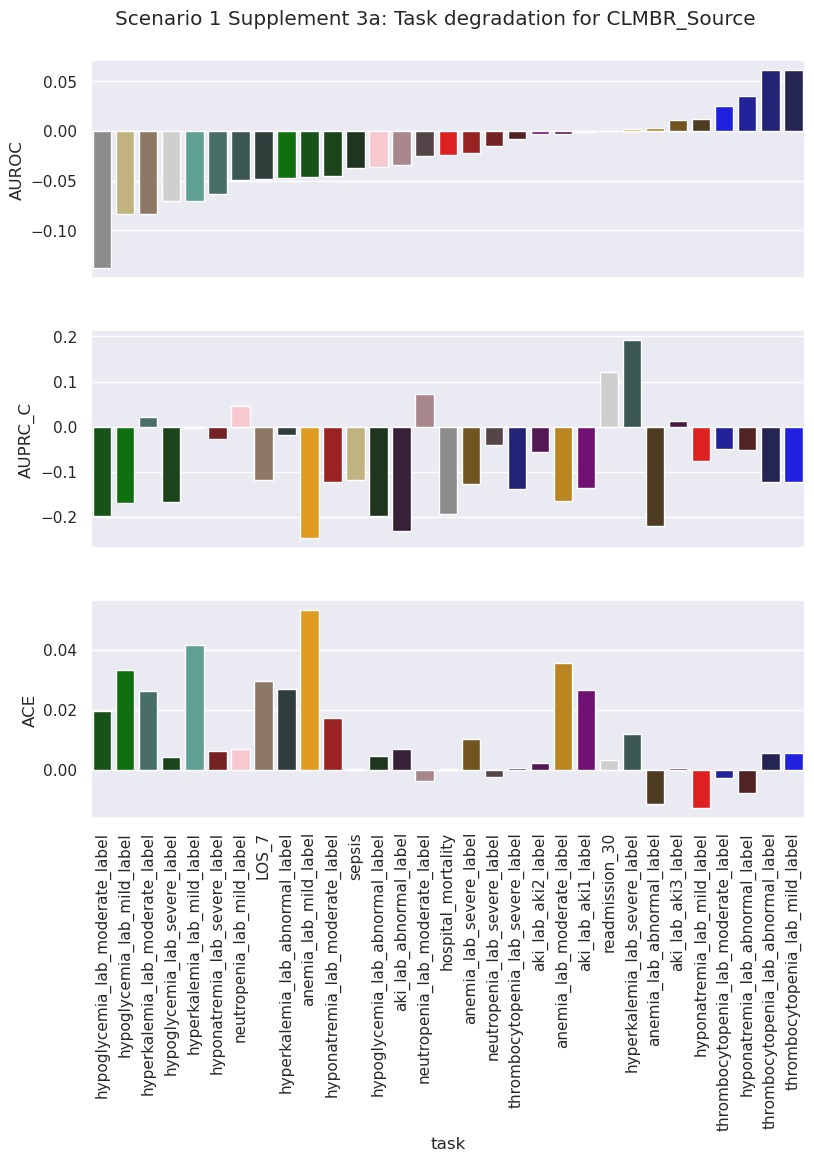

In [199]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(8,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Supplement 3a for Scenario 1, showing degradation from worst to best
fig.suptitle('Scenario 1 Supplement 3a: Task degradation for CLMBR_Source')
task_order = None
for r, metric in enumerate(metrics):
    df = plot_dict['s1s3'][metric]
    id_df = df.query('Test=="ad"')
    ood_df = df.query('Test=="ped"')
    df = id_df
    df['Performance'] = ood_df['Performance'] - id_df['Performance']
    if metric == 'auc':
        df = df.sort_values(by='Performance')
        task_order = list(df['task'].values)
        print(task_order)
    bp = sns.barplot(x="task", y="Performance", order=task_order, data=df,ax=axs[r],  hue="task", palette=sns.color_palette(palette_list), dodge=False)
    bp.legend_.remove()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
axs[-1].tick_params(axis='x', rotation=90)
# increase dpi, reduce figsiz
#fix styling

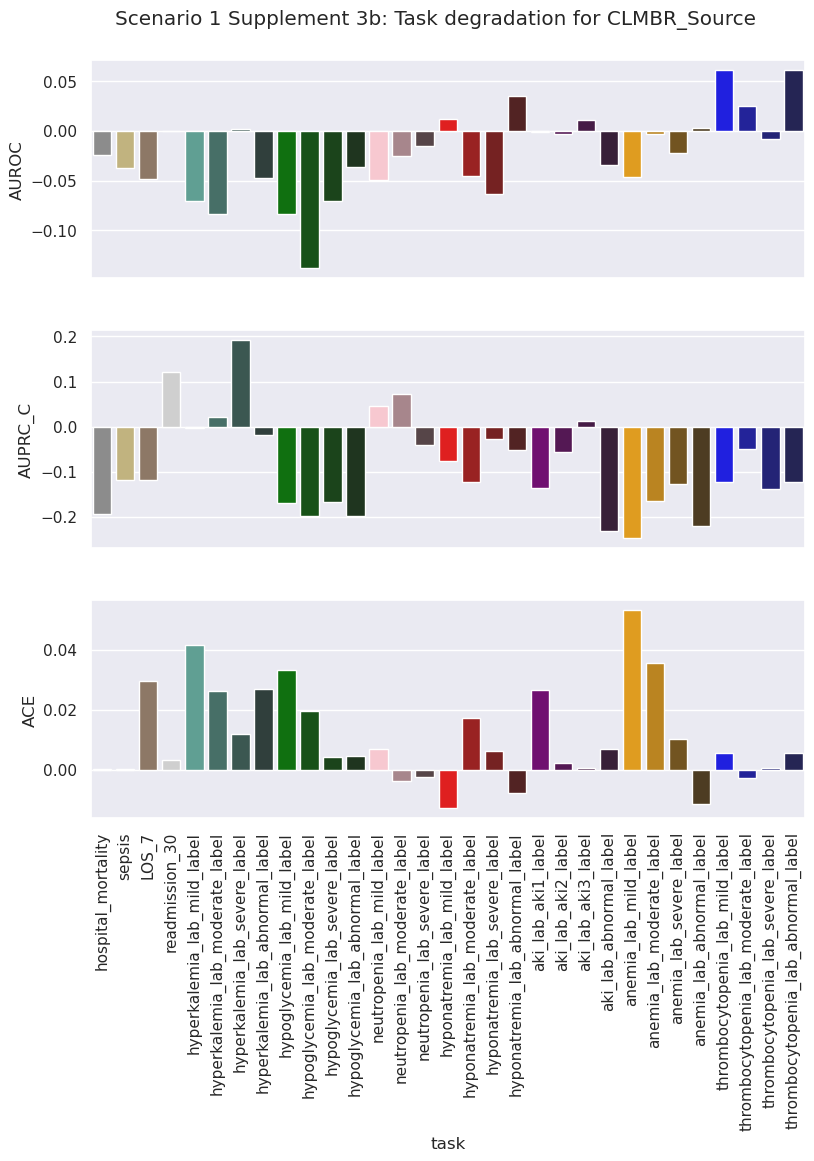

In [181]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(8,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Supplement 3b for Scenario 1, showing degradation across groups
fig.suptitle('Scenario 1 Supplement 3b: Task degradation for CLMBR_Source')
for r, metric in enumerate(metrics):
    df = plot_dict['s1s3'][metric]
    id_df = df.query('Test=="ad"')
    ood_df = df.query('Test=="ped"')
    df = id_df
    df['Performance'] = ood_df['Performance'] - id_df['Performance']
    bp = sns.barplot(x="task", y="Performance", data=df,ax=axs[r],  hue="task", palette=sns.color_palette(palette_list),dodge=False)
#     bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r]) #hue=model, color_palette=model_colors
#     sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='task',  palette=sns.color_palette(palette_list), ax=axs[r])
#     print(df)
#     lp = sns.lineplot(x="Model", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r])
#     h,l = sp.axes.get_legend_handles_labels()
    bp.legend_.remove()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])
axs[-1].tick_params(axis='x', rotation=90)
# increase dpi, reduce figsiz
#fix styling

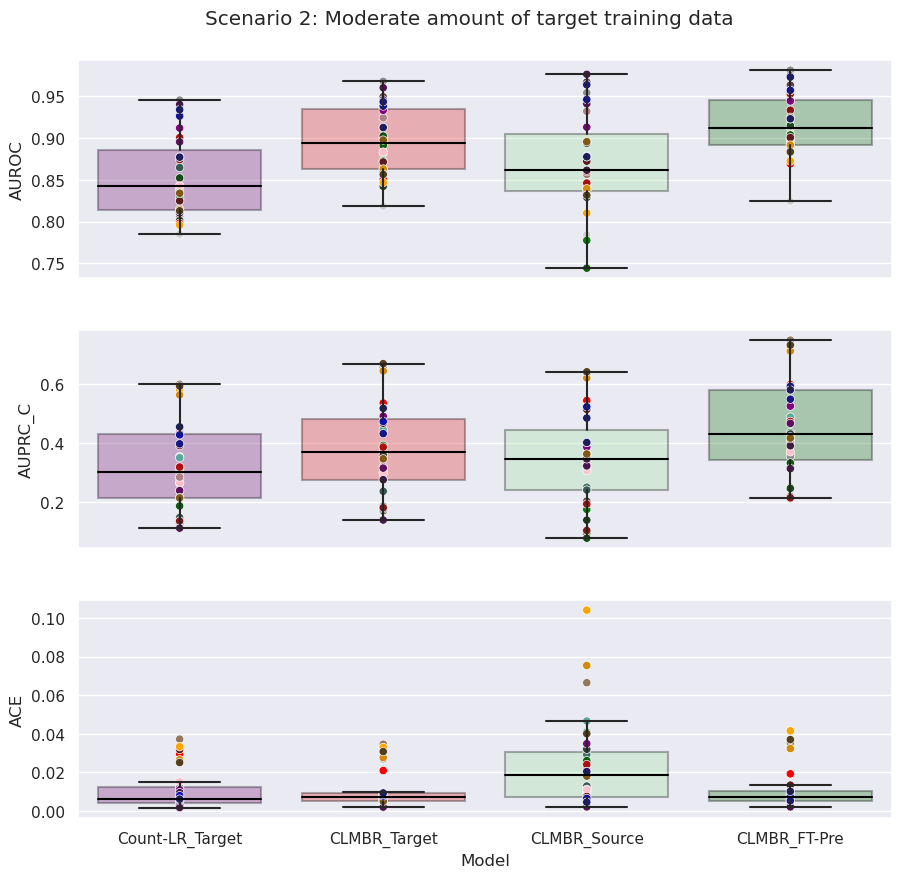

In [200]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(9,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 1
fig.suptitle('Scenario 2: Moderate amount of target training data ')
for r, metric in enumerate(metrics):
    df = plot_dict['s2m'][metric]
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='task',  palette=sns.color_palette(palette_list), ax=axs[r])
#     print(df)
#     lp = sns.lineplot(x="Model", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r])
    h,l = sp.axes.get_legend_handles_labels()
    sp.legend_.remove()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])

# sp.fig.legend(h,l, ncol=6)

# increase dpi, reduce figsiz
#fix styling

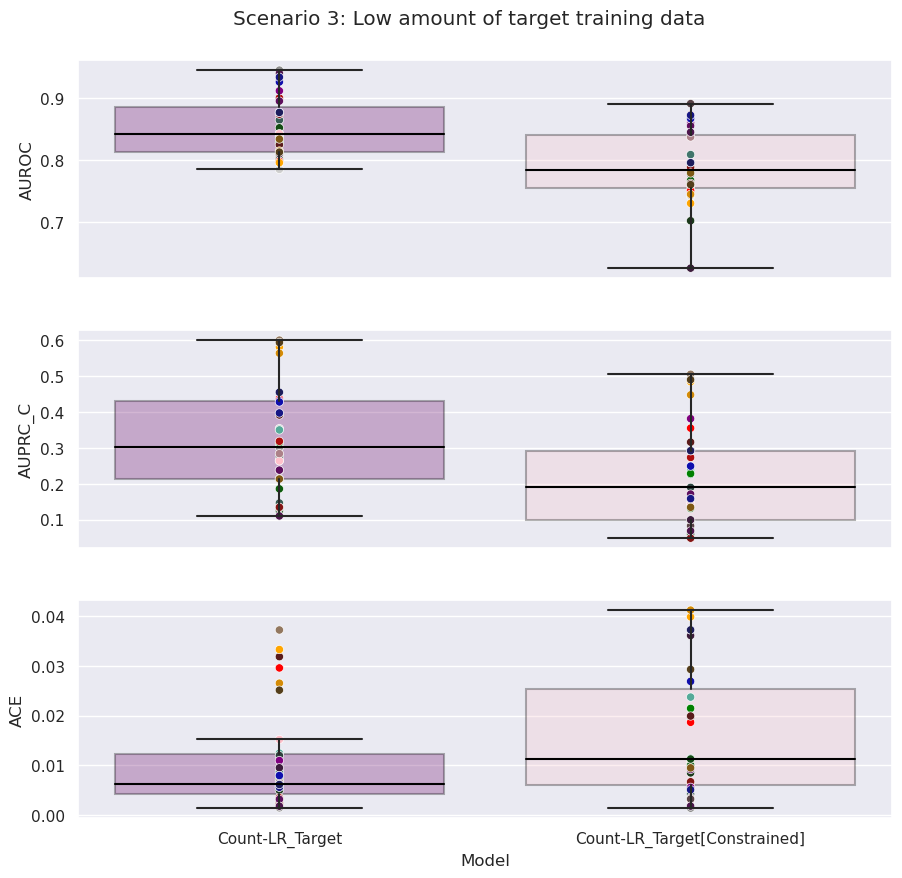

In [209]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':500})
fig, axs = plt.subplots(nrows=3, figsize=(9,9))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Main figure for Scenario 3
fig.suptitle('Scenario 3: Low amount of target training data ')
for r, metric in enumerate(metrics):
    df = plot_dict['s3m'][metric]
    bp = sns.boxplot(x="Model", y="Performance", data=df, showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, ax=axs[r], palette=model_colours)
    sp = sns.scatterplot(x="Model",  y="Performance", data=df, hue='task',  palette=sns.color_palette(palette_list), ax=axs[r])
#     print(df)
#     lp = sns.lineplot(x="Model", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False, alpha=0.1, ax=axs[r])
    h,l = sp.axes.get_legend_handles_labels()
    sp.legend_.remove()
    axs[r].set_ylabel(y_axis[metric]['label'])
    if r != len(metrics)-1:
        axs[r].set_xlabel('')
        axs[r].set(xticklabels=[])

# sp.fig.legend(h,l, ncol=6)

# increase dpi, reduce figsiz
#fix styling

In [ ]:
metric = 'auc'
sns.set(rc={'figure.figsize':(20,12)})
bp = sns.boxplot(x="Model", y="Performance", data=plot_dict['s2m'][metric], showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, )
sp = sns.stripplot(x="Model", y="Performance", data=plot_dict['s2m'][metric], edgecolor='black', linewidth=1, hue='task', s=9, dodge=True, palette=sns.color_palette(palette_list))

# get jittered x positions to plot line plot overlay
# x = []
# y = []
# task = []
# model = []
# i = 0
# for d in sp.collections:
#     if len(d.get_offsets().data) > 0:
#         x.append(d.get_offsets().data[0][0])
#         y.append(d.get_offsets().data[0][1])
#         df = plot_dict[metric].iloc[i]
#         task.append(df['task'])
#         model.append(df['Model'])
#         i += 1
# df = pd.DataFrame({'x':x,'Performance':y,'task':task,'Model':model})
# lp = sns.lineplot(x="x", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False)
# h,l = sp.axes.get_legend_handles_labels()
sp.legend_.remove()
# sp.fig.legend(h,l, ncol=6)

In [ ]:
metric = 'auprc'
sns.set(rc={'figure.figsize':(20,12)})
bp = sns.boxplot(x="Model", y="Performance", data=plot_dict['s2'][metric], showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, )
sp = sns.stripplot(x="Model", y="Performance", data=plot_dict['s2'][metric], edgecolor='black', linewidth=1, hue='task', s=9, dodge=True, palette=sns.color_palette(palette_list))

# get jittered x positions to plot line plot overlay
# x = []
# y = []
# task = []
# model = []
# i = 0
# for d in sp.collections:
#     if len(d.get_offsets().data) > 0:
#         x.append(d.get_offsets().data[0][0])
#         y.append(d.get_offsets().data[0][1])
#         df = plot_dict[metric].iloc[i]
#         task.append(df['task'])
#         model.append(df['Model'])
#         i += 1
# df = pd.DataFrame({'x':x,'Performance':y,'task':task,'Model':model})
# lp = sns.lineplot(x="x", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False)
# h,l = sp.axes.get_legend_handles_labels()
sp.legend_.remove()
# sp.fig.legend(h,l, ncol=6)

In [ ]:
metric = 'ace_abs_logistic_logit'
sns.set(rc={'figure.figsize':(20,12)})
bp = sns.boxplot(x="Model", y="Performance", data=plot_dict[metric], showfliers = False, boxprops={'edgecolor':'black', 'alpha':0.3}, medianprops={"color": "black"}, )
sp = sns.stripplot(x="Model", y="Performance", data=plot_dict[metric], edgecolor='black', linewidth=1, hue='task', s=9, dodge=True, palette=sns.color_palette(palette_list))

# get jittered x positions to plot line plot overlay
# x = []
# y = []
# task = []
# model = []
# i = 0
# for d in sp.collections:
#     if len(d.get_offsets().data) > 0:
#         x.append(d.get_offsets().data[0][0])
#         y.append(d.get_offsets().data[0][1])
#         df = plot_dict[metric].iloc[i]
#         task.append(df['task'])
#         model.append(df['Model'])
#         i += 1
# df = pd.DataFrame({'x':x,'Performance':y,'task':task,'Model':model})
# lp = sns.lineplot(x="x", y="Performance", hue='task', data=df, palette=sns.color_palette(palette_list), dashes=True, legend=False)
# h,l = sp.axes.get_legend_handles_labels()
sp.legend_.remove()
# sp.fig.legend(h,l, ncol=6)

In [ ]:
# plot y-axis change in performance from ID -> OOD
# for scenario 1 CLMBR_source only
# x-axis tasks (either best to worst or in task groups)

In [210]:
import os
import argparse
import yaml
import shutil
import pdb
import torch
import joblib

import pandas as pd
import numpy as np

from itertools import zip_longest
from subprocess import (run, Popen)
from prediction_utils.util import str2bool
from ehr_ml.clmbr import convert_patient_data
from sklearn.model_selection import ParameterGrid
import random

from ehr_ml.extension.timeline import TimelineReader